# Bank Marketing Classification

## 1. Introduction

This notebook demonstrates a complete machine learning workflow for a tabular classification task. We will use the Bank Marketing dataset from the UCI Machine Learning Repository to predict whether a customer will subscribe to a term deposit.

The workflow covers the following steps:
1.  **Data Loading and Initial Exploration**: Loading the data and getting a first look at its structure.
2.  **Data Preprocessing and Cleaning**: Renaming columns, correcting data types, and handling missing values.
3.  **Exploratory Data Analysis (EDA)**: Visualizing the data to understand feature distributions and relationships.
4.  **Feature Engineering**: Preparing the data for modeling by scaling and encoding features.
5.  **Model Training**: Training multiple classification models.
6.  **Model Evaluation**: Evaluating model performance using various metrics.
7.  **Prediction**: Using the trained models to make predictions on new data.

## 2. Setup: Import Libraries

In [1]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                                roc_auc_score, roc_curve,auc)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

## 3. Data Loading

In [2]:
# Load data
notebook_path = Path.cwd()
file_path = notebook_path.parent / 'dataset' / 'bank.csv'
print(f"Loading data from: {file_path}")
data = pd.read_csv(file_path, header=0, sep=';')

Loading data from: /home/tisinr/Dev/models/classifier/dataset/bank.csv


## 4. Data Preprocessing and Cleaning

In [3]:
def rename_n_change(data):
    # Rename columns for better readability
    data.rename(columns={
        'marital':'marital_status',
        'default':'credit_default',
        'housing':'housing_loan',
        'loan':'personal_loan',
        'y':'response'}, inplace=True)
    #change data types for faster loading
    data['response'] = data['response'].astype('category')
    data['marital_status'] = data['marital_status'].astype('category')
    data['education'] = data['education'].astype('category')
    data['job'] = data['job'].astype('category')
    data['contact'] = data['contact'].astype('category')
    data['month'] = data['month'].astype('category')
    data['day'] = data['day'].astype('category')
    data['credit_default'] = data['credit_default'].astype('category')
    data['housing_loan'] = data['housing_loan'].astype('category')
    data['personal_loan'] = data['personal_loan'].astype('category')
    return data
data=rename_n_change(data)

### 4.1. Handle Missing Values

We check the `poutcome` column for missing values and drop it since it contains over 80% unknown values.

In [4]:
data['poutcome'].value_counts(dropna=False)/len(data)*100

poutcome
unknown    81.747805
failure    10.840282
other       4.069806
success     3.342107
Name: count, dtype: float64

In [5]:
# Drop poutcome with more than 80% unknown values
data.drop('poutcome', axis=1, inplace=True)

## 5. Exploratory Data Analysis (EDA)

### 5.1. Check for Data Imbalance

We visualize the distribution of the target variable `response` to check for class imbalance.

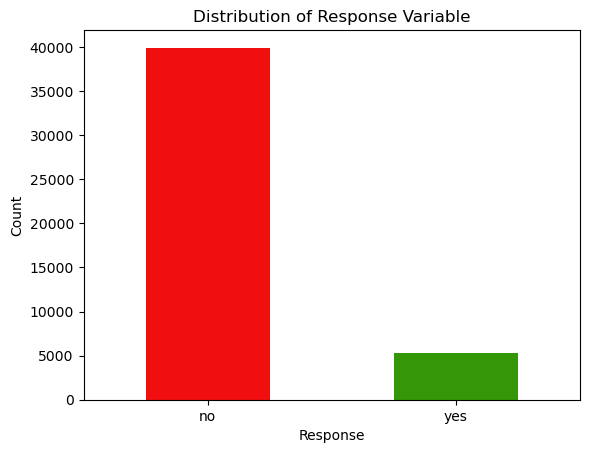

In [6]:
data['response'].value_counts().plot(kind='bar', color=["#F00E0E", "#339708"])
plt.title('Distribution of Response Variable')
plt.xlabel('Response')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### 5.2. Visualize Feature Distributions

We use Seaborn to create various plots to understand the distribution of individual features and their relationships with the target variable.

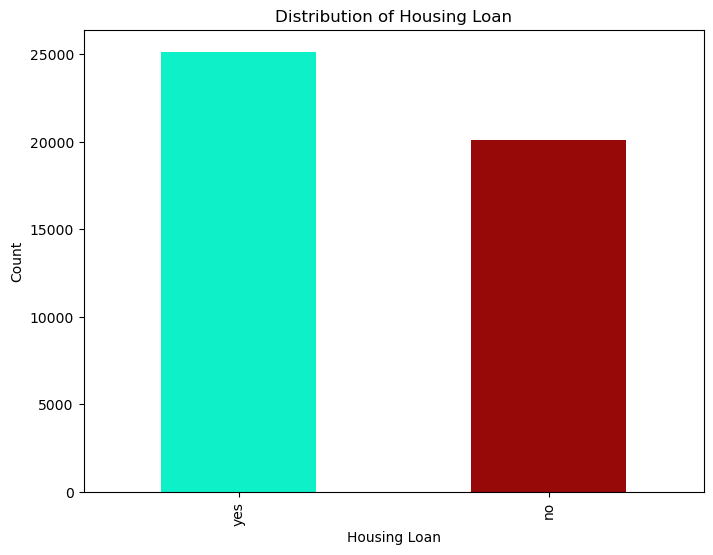

In [7]:
plt.figure(figsize=(8, 6))
data['housing_loan'].value_counts().plot(kind='bar',color=["#0EF0C7", "#970808"])
plt.title('Distribution of Housing Loan')
plt.xlabel('Housing Loan')
plt.ylabel('Count')
plt.show()

### 5.3. Correlation Matrix

We create a correlation matrix to understand the relationships between numeric features.

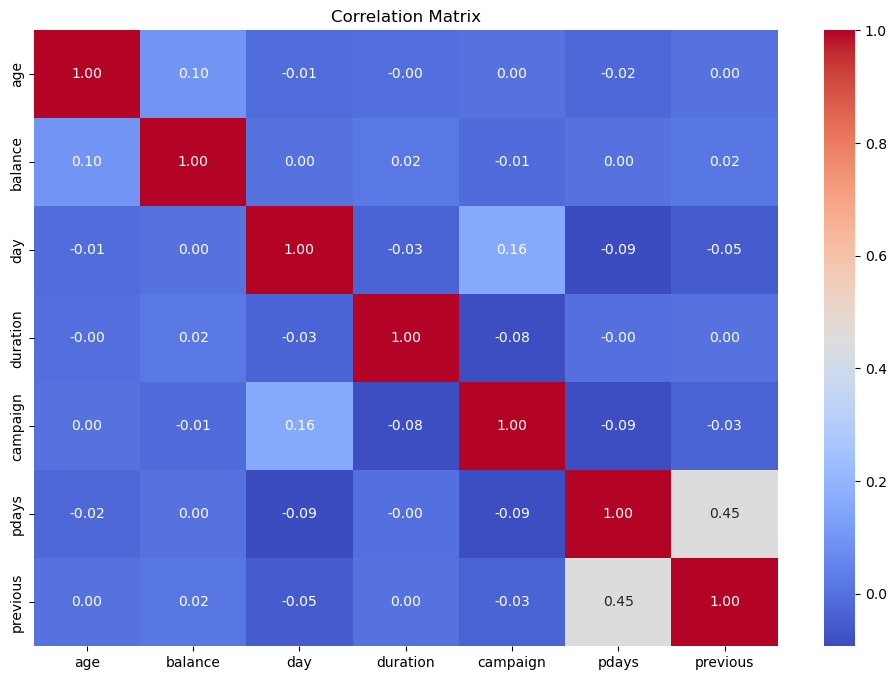

In [8]:
#Correlation matrix for numeric features
plt.figure(figsize=(12, 8))
numeric_ft = data[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']]
corr_matrix = numeric_ft.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


## 6. Feature Engineering and Data Splitting

### 6.1. Assign Features and Labels

We separate the dataset into features (X) and the target variable (y).

In [9]:
X=data.drop(columns=['response'])
y=data['response']
print(X.shape)
print(y.shape)

(45211, 15)
(45211,)


### 6.2. Split Data into Training and Testing Sets

In [10]:
#Split the data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=78)

## 7. Data Transformation Pipeline

In [11]:
# Separate numeric and categorical features
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital_status', 'education', 'month', 'housing_loan', 'personal_loan', 'contact', 'credit_default']

In [12]:
# Create a column transformer to apply different preprocessing steps to different columns
pre_processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# Create a pipeline that first applies the preprocessor and then fits a classifier
pre_pipeline = Pipeline(steps=[
    ('preprocessor', pre_processor)
])


### 7.1. Label Encode Target Variable

In [13]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### 7.2. Apply Preprocessing to Data

In [14]:
# Fit preprocessing on training data and transform both sets
X_train = pre_pipeline.fit_transform(X_train)
X_test = pre_pipeline.transform(X_test)  # No fitting on test data!

In [15]:
print(X_train.shape)
print(X_test.shape)


(36168, 47)
(9043, 47)


### 7.3. Handle Class Imbalance with SMOTE

We use Synthetic Minority Over-sampling Technique (SMOTE) to address the class imbalance in the training data.

In [16]:
smote = SMOTE()
X_train,y_train = smote.fit_resample(X_train, y_train) # type: ignore

## 8. Model Training and Evaluation

In [17]:
#Instantiate and train
logreg=LogisticRegression(class_weight= 'balanced')
dtree=DecisionTreeClassifier()
rforest=RandomForestClassifier(class_weight= 'balanced',n_estimators=100)
gbm=GradientBoostingClassifier()
gnb=GaussianNB()
knn=KNeighborsClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

[LightGBM] [Info] Number of positive: 31937, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11787
[LightGBM] [Info] Number of data points in the train set: 63874, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


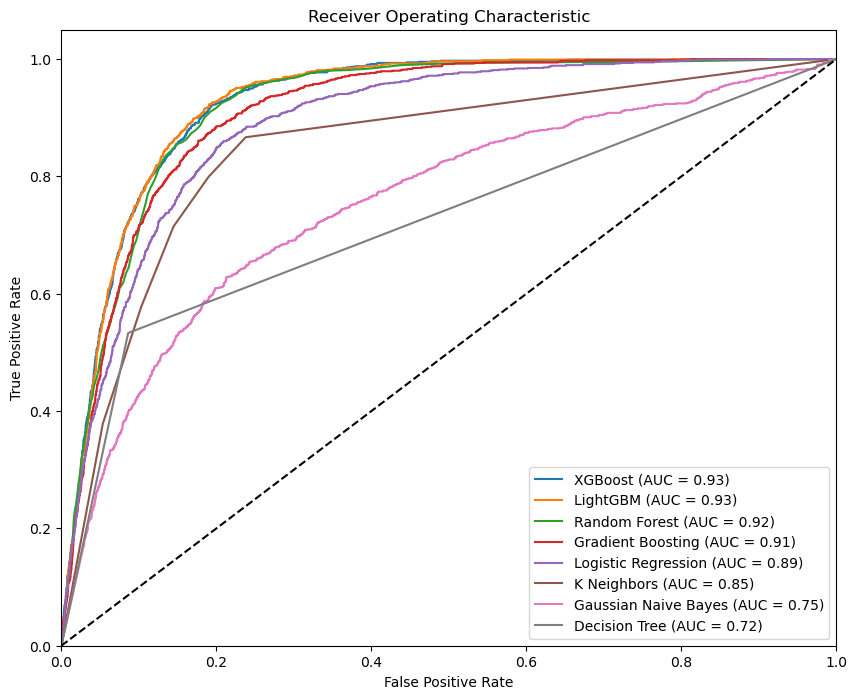

In [18]:
# Predict, Evaluate and plot
models = {"XGBoost": xgb, "LightGBM": lgbm,"Random Forest": rforest, "Gradient Boosting": gbm,"Logistic Regression": logreg,"K Neighbors": knn,"Gaussian Naive Bayes": gnb,"Decision Tree": dtree}
results = pd.DataFrame(columns=['Model', 'Accuracy', 'ROC_AUC_Score'])
plt.figure(figsize=(10, 8))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    new_row = pd.DataFrame([{'Model': name, 'Accuracy': accuracy, 'ROC_AUC_Score': roc_auc}])
    results = pd.concat([results, new_row], ignore_index=True)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [19]:
# Sort the results by ROC_AUC_Score in descending order
results = results.sort_values(by='ROC_AUC_Score', ascending = False,ignore_index = True)
# Display the results
print(results)

                  Model  Accuracy  ROC_AUC_Score
0              LightGBM  0.898817       0.926038
1               XGBoost  0.900365       0.925084
2         Random Forest  0.892735       0.918343
3     Gradient Boosting  0.871060       0.909888
4   Logistic Regression  0.826053       0.890510
5           K Neighbors  0.838881       0.846285
6  Gaussian Naive Bayes  0.742784       0.754755
7         Decision Tree  0.869291       0.723460


### 8.1. Confusion Matrix

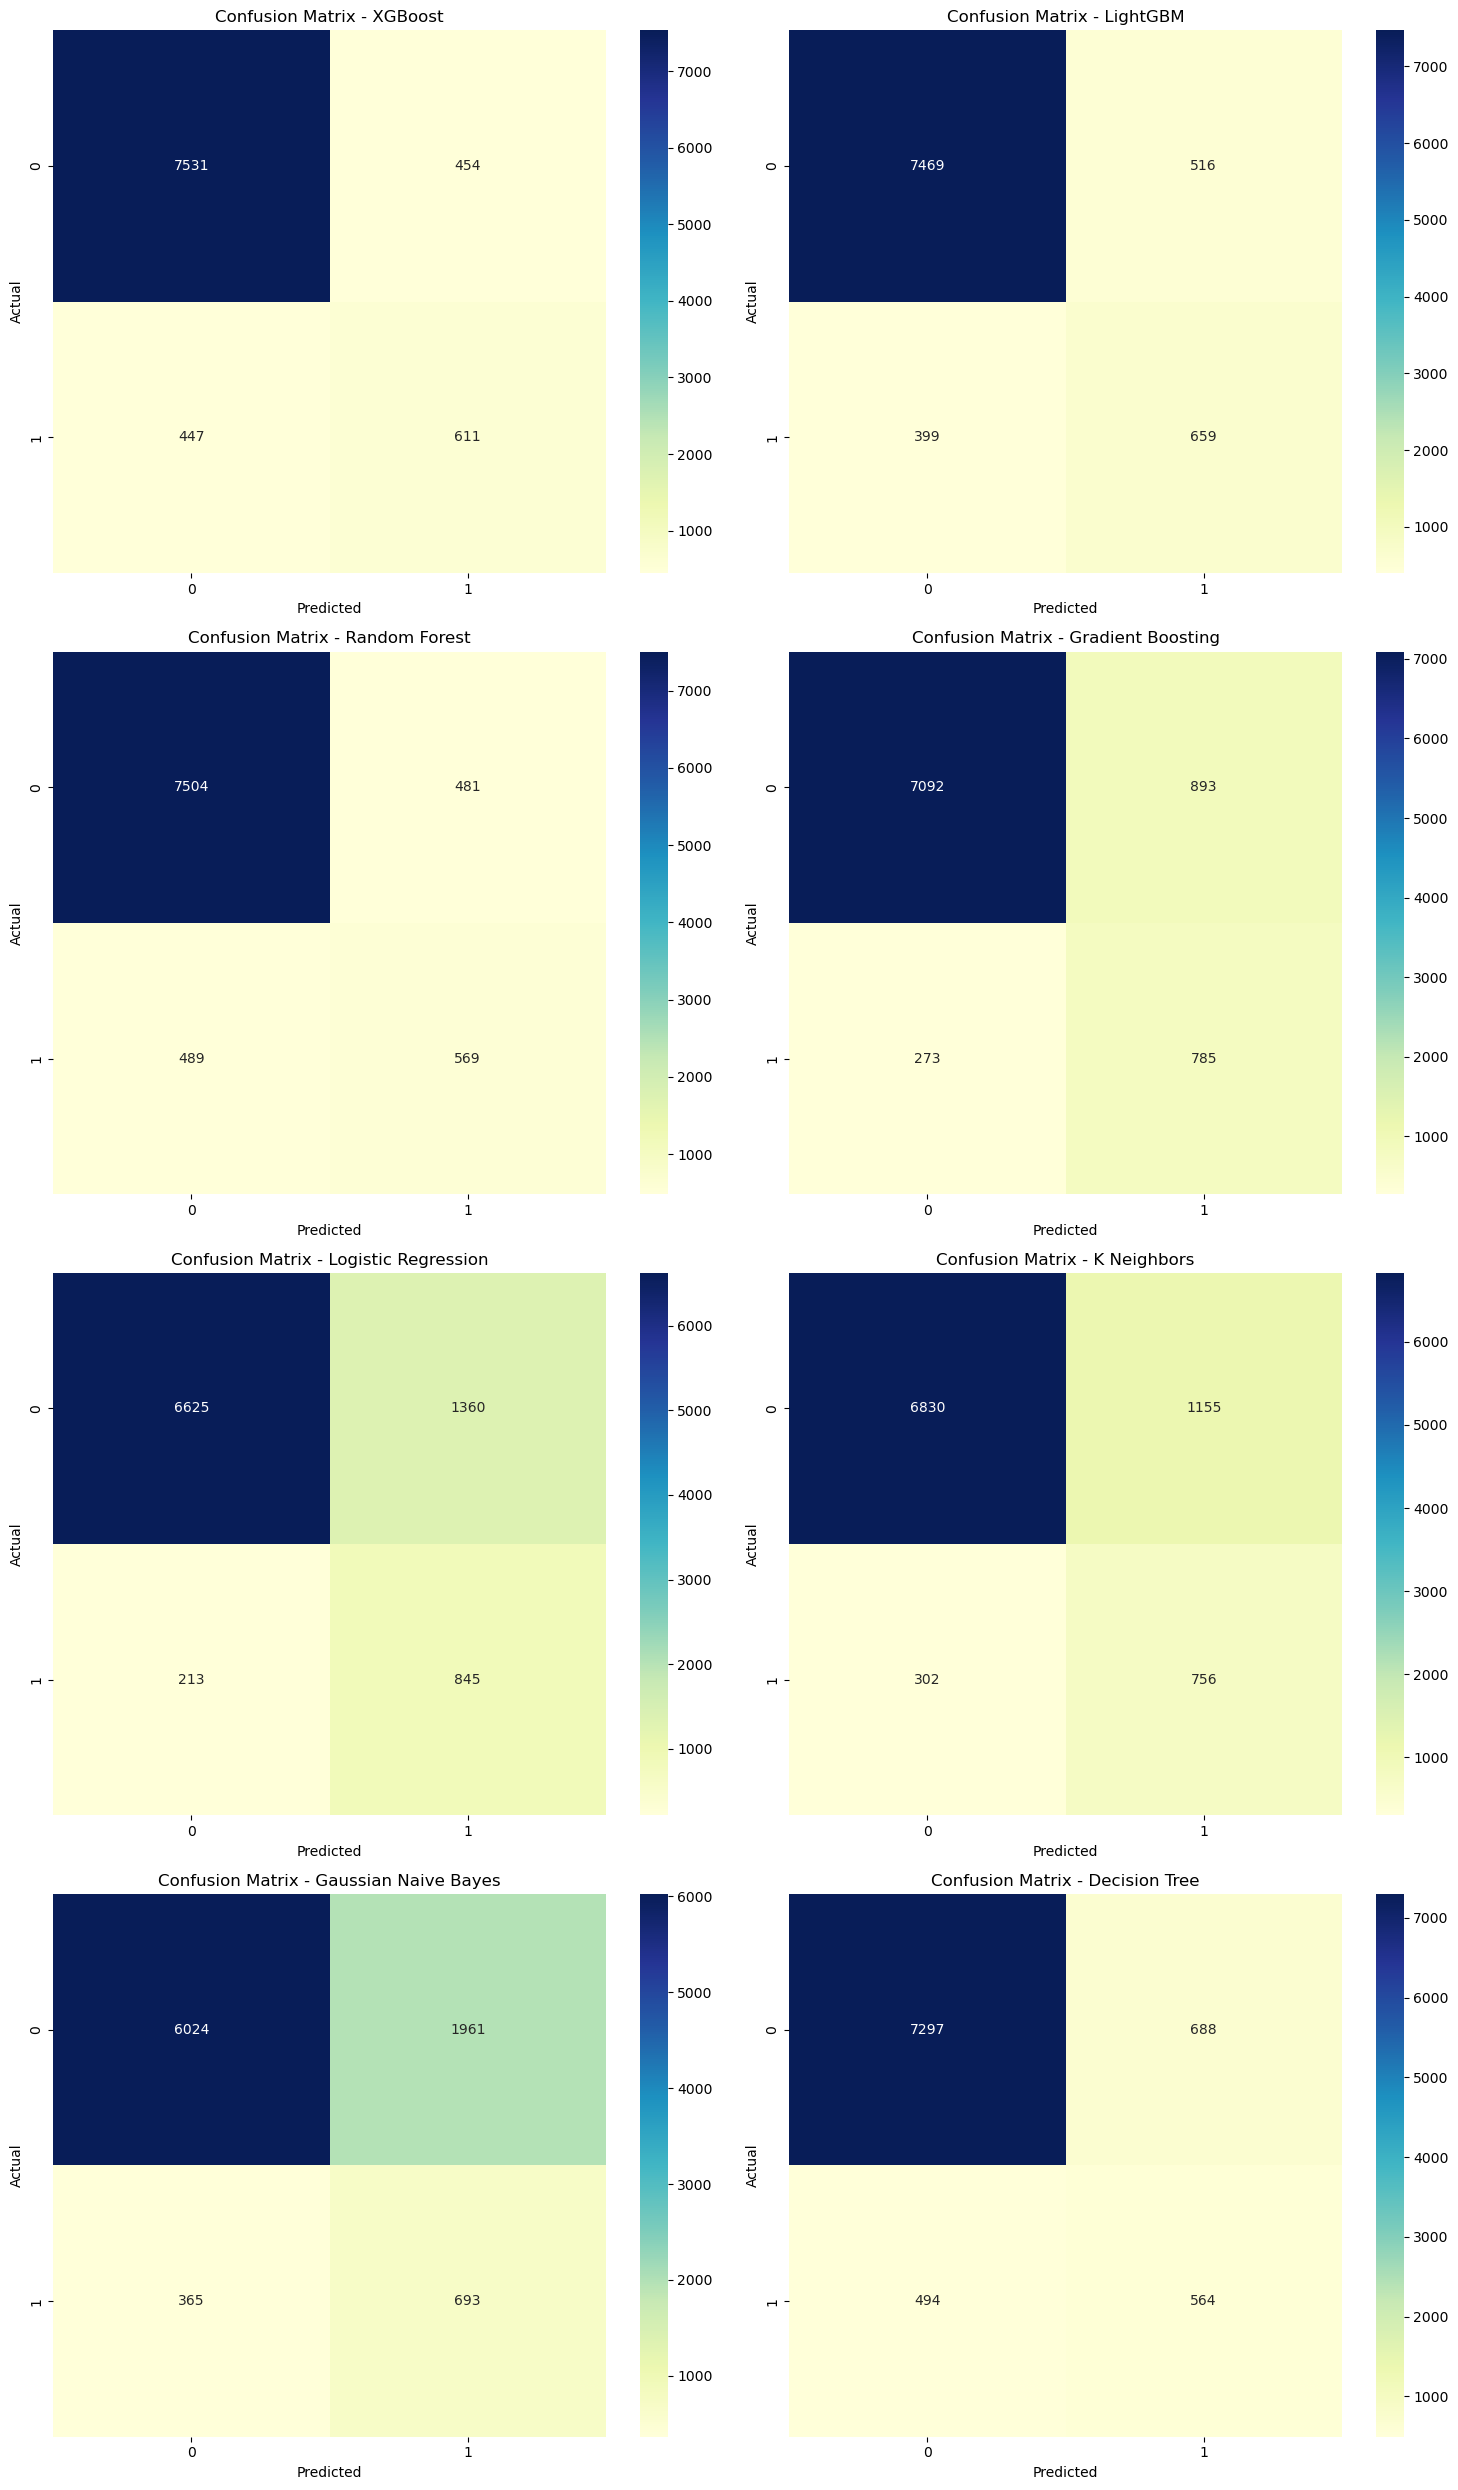

In [59]:
# Plot confusion matrices for each model
fig, axes = plt.subplots(4, 2, figsize=(15, 25))
axes = axes.ravel()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='YlGnBu')
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('../plots/confusion_matrices.png')
plt.show()

## 9. Model Persistence

In [ ]:
# Save the model
joblib.dump(logreg, '../saved_models/logreg_model.pkl')
joblib.dump(dtree, '../saved_models/dtree_model.pkl')
joblib.dump(rforest, '../saved_models/rforest_model.pkl')
joblib.dump(gbm, '../saved_models/gbm_model.pkl')
joblib.dump(gnb, '../saved_models/gnb_model.pkl')
joblib.dump(knn, '../saved_models/knn_model.pkl')
joblib.dump(xgb, '../saved_models/xgb_model.pkl')
joblib.dump(lgbm, '../saved_models/lgbm_model.pkl')
joblib.dump(pre_pipeline, '../saved_models/pre_pipeline.pkl')
joblib.dump(label_encoder, '../saved_models/label_encoder.pkl')

## 10. Prediction on New Data

In [ ]:
# Load the model
logreg_ = joblib.load('../saved_models/logreg_model.pkl')
dtree_ = joblib.load('../saved_models/dtree_model.pkl')
rforest_ = joblib.load('../saved_models/rforest_model.pkl')
gbm_ = joblib.load('../saved_models/gbm_model.pkl')
gnb_ = joblib.load('../saved_models/gnb_model.pkl')
knn_ = joblib.load('../saved_models/knn_model.pkl')
xgb_ = joblib.load('../saved_models/xgb_model.pkl')
lgbm_ = joblib.load('../saved_models/lgbm_model.pkl')
pre_pipeline_ = joblib.load('../saved_models/pre_pipeline.pkl')
label_encoder_ = joblib.load('../saved_models/label_encoder.pkl')

In [ ]:
# Make predictions on new data
new_data = pd.DataFrame({
    'age': [30],
    'balance': [1000],
    'day': [15],
    'duration': [200],
    'campaign': [1],
    'pdays': [999],
    'previous': [0],
    'job': ['admin.'],
    'contact': ['cellular'],
    'marital_status': ['single'],
    'education': ['university.degree'],
    'month': ['may'],
    'housing_loan': ['yes'],
    'personal_loan': ['no'],
    'credit_default': ['no']
})

In [ ]:
# Preprocess the new data
new_d = pd.DataFrame(pre_pipeline_.transform(new_data), columns=pre_pipeline_.get_feature_names_out()) # type: ignore

In [ ]:

# Make predictions
logreg_pred = logreg_.predict(new_d)
dtree_pred = dtree_.predict(new_d)
rforest_pred = rforest_.predict(new_d)
gbm_pred = gbm_.predict(new_d)
gnb_pred = gnb_.predict(new_d)
knn_pred = knn_.predict(new_d)
xgb_pred = xgb_.predict(new_d)
lgbm_pred = lgbm_.predict(new_d)
# Print the predictions
print("XGBoost Prediction: ", xgb_pred)
print("LightGBM Prediction: ", lgbm_pred)
print("Random Forest Prediction: ", rforest_pred)
print("Gradient Boosting Prediction: ", gbm_pred)
print("Gaussian Naive Bayes Prediction: ", gnb_pred)
print("Logistic Regression Prediction: ", logreg_pred)
print("Decision Tree Prediction: ", dtree_pred)
print("K Neighbors Prediction: ", knn_pred)